## Introduction
In this project, I try to optimize a supervised machine learning algorithm to predict Myers-Briggs personality profiles of Kaggle forum users based on the [(MBTI) Myers-Briggs Personality Type Dataset](https://www.kaggle.com/datasnaek/mbti-type) on Kaggle. 

This notebook was forked from [this](https://www.kaggle.com/lbronchal/what-s-the-personality-of-kaggle-users) Kaggle kernel. 

In [2]:
import re
from time import time
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer

In [3]:
train_data = pd.read_csv('../mbti-project/mbti_1.csv')
user_data = pd.read_csv('../mbti-project/Users.csv')
forum_data = pd.read_csv('../mbti-project/ForumMessages.csv')
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}

Let's look at the structure of the dataset.

In [4]:
train_data.shape

(8675, 2)

Let's look at the distribution of personality profile types in the training data.

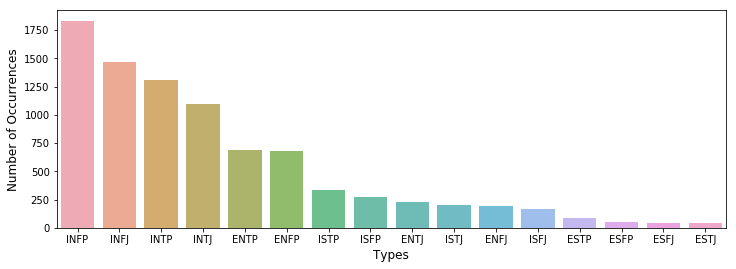

In [5]:
type_count = train_data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(type_count.index, type_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

The personality types seems to be heavily skewed to the right.

## Handle missing values

Let's see if there are missing values in our data.

In [6]:
print('Forum Missing Values:')
print(forum_data.isnull().sum())
print('\n')
print('User Missing Values:')
print(user_data.isnull().sum())
print('\n')
print('Training Missing Values:')
print(train_data.isnull().sum())

Forum Missing Values:
Id                           0
ForumTopicId                 0
AuthorUserId                 0
PostDate                     0
Message                    581
ReplyToForumMessageId    70620
TopicMessagePosition         0
RawMarkdown              60694
Score                        0
FlaggedCount                 0
dtype: int64


User Missing Values:
Id                     0
UserName          267200
DisplayName           21
RegisterDate           0
Points            510138
Ranking           510138
Tier                   0
HighestRanking    510132
dtype: int64


Training Missing Values:
type     0
posts    0
dtype: int64


Fill missing values for `forum_data['Message']` with blank space.

In [7]:
forum_data['Message'] = forum_data['Message'].fillna('')

print('Forum Missing Values:')
print(forum_data.isnull().sum())

Forum Missing Values:
Id                           0
ForumTopicId                 0
AuthorUserId                 0
PostDate                     0
Message                      0
ReplyToForumMessageId    70620
TopicMessagePosition         0
RawMarkdown              60694
Score                        0
FlaggedCount                 0
dtype: int64


In [8]:
print(forum_data['AuthorUserId'].value_counts())

3258      1459
993       1353
2242      1191
59561     1011
5309       913
114978     699
1828       679
100236     604
6696       510
24266      499
317687     488
75837      451
2505       436
140793     390
368        377
23831      376
3716       375
263583     362
111776     341
147404     323
1335       320
4398       315
37404      310
111640     284
102203     264
381        263
2194       253
10035      239
2036       239
131576     237
          ... 
138735       1
2839         1
201524       1
217916       1
111072       1
405968       1
80305        1
391593       1
231655       1
116975       1
80113        1
170245       1
49422        1
55030        1
10515        1
31001        1
233764       1
366885       1
397037       1
217404       1
145130       1
158043       1
637281       1
51599        1
405904       1
358082       1
155303       1
131478       1
389544       1
14329        1
Name: AuthorUserId, Length: 13340, dtype: int64


Since a given user might have posted more than once on Kaggle forums, I will group all `'Message'` together for each unique user.

In [9]:
forum_data_agg = forum_data.groupby('AuthorUserId')['Message'].agg(lambda col: ' '.join(col)).reset_index()

In [10]:
print(forum_data_agg['AuthorUserId'].value_counts())

71677     1
151016    1
494738    1
2708      1
126473    1
121486    1
19084     1
27272     1
605816    1
33413     1
43648     1
643711    1
518776    1
137846    1
45683     1
47730     1
43632     1
348783    1
62059     1
326250    1
21284     1
27240     1
397927    1
203366    1
33381     1
23198     1
144035    1
129706    1
105158    1
552523    1
         ..
406442    1
277709    1
13516     1
595094    1
449793    1
617783    1
58666     1
320822    1
294197    1
301551    1
118067    1
77103     1
146733    1
13612     1
38022     1
345378    1
87328     1
7108      1
629725    1
40435     1
202008    1
58646     1
51550     1
96258     1
285969    1
61922     1
9486      1
460042    1
138505    1
327680    1
Name: AuthorUserId, Length: 13340, dtype: int64


## Cleaning data

First, I'll clean the text from the training data posts as well as the Kaggle forum data posts.

In [11]:
#function to clean data
def clean_text(text):
    #get rid of html and seperators
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r'  ', text) 
    text = re.sub(r'http\S+', r'  ', text)
    #get rid of punctuation
    text = text.replace('.', '  ')
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    #get rid of numbers
    text = ''.join(i for i in text if not i.isdigit())
    return text

In [12]:
train_data['clean_posts'] = train_data['posts'].apply(clean_text)

In [13]:
print(train_data['clean_posts'][1])

Im finding the lack of me in these posts very alarming    Sex can be boring if its in the same position often   For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary   There isnt enough        Giving new meaning to Game theory    Hello ENTP Grin  Thats all it takes   Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins    This  Lack of Balance and Hand Eye Coordination    Real IQ test I score    Internet IQ tests are funny   I score s or higher    Now like the former responses of this thread I will mention that I dont believe in the IQ test   Before you banish        You know youre an ENTP when you vanish from a site for a year and a half return and find people are still commenting on your posts and liking your ideasthoughts   You know youre an ENTP when you                I over think things sometimes   I go by the old Sher

In [14]:
forum_data_agg['clean_messages'] = forum_data_agg['Message'].apply(clean_text)

In [15]:
print(forum_data_agg['clean_messages'][1])

The public leaderboard is only indicative because competitors can use information on their score to get information on a portion of the test dataset   The final results are a quite different and b better reflect actual performance   Hi Tanya Kaggle will maintain a rating system   If you win but youre ineligible for prize money you will still get a strong rating  Anthony GiovanniThanks for your feedback   Using the forum to give feedback is a good idea   It allows others to see and comment on suggestions   We might set up a proper feedback forum but for the moment this topic will have to suffice   I also agree that the forum is a bit clunky   However we have a large list of feature requests and only limited resources for the moment  it might take us some time to address this   Apologies   I dont think the prize money in this competition is that relevant the prize is relatively small   Correct me if Im wrong but I think contestants are driven by intrinsic factors  A karma system that rew

The training data looks good, but the Kaggle forum messages are almost cleaned except there are certain words that are fused together like `'mindAnthony'` and `'CommunityForum'`. I will need to split those words apart before I stem or else it won't work properly.

In [16]:
#function to split string by uppercase
def split_uppercase(text):
    text_list = text.split()
    new_list = []
    for i in text_list:
        if i.isupper() == False: #don't split acronyms
            word = re.sub(r'([A-Z])', r' \1', i)
            new_list.append(word)
        else:
            word = i
            new_list.append(word)
    words = ' '.join(new_list)
    return words
            

In [17]:
forum_data_agg['clean_messages'] = forum_data_agg['clean_messages'].apply(split_uppercase)

In [18]:
print(forum_data_agg['clean_messages'][1])

 The public leaderboard is only indicative because competitors can use information on their score to get information on a portion of the test dataset  The final results are a quite different and b better reflect actual performance  Hi  Tanya  Kaggle will maintain a rating system  If you win but youre ineligible for prize money you will still get a strong rating  Anthony  Giovanni Thanks for your feedback  Using the forum to give feedback is a good idea  It allows others to see and comment on suggestions  We might set up a proper feedback forum but for the moment this topic will have to suffice I also agree that the forum is a bit clunky  However we have a large list of feature requests and only limited resources for the moment it might take us some time to address this  Apologies I dont think the prize money in this competition is that relevant the prize is relatively small  Correct me if  Im wrong but I think contestants are driven by intrinsic factors A karma system that rewards foru

Looks much better. Now that the train posts and forum posts are cleaned, I'll stem them.

In [19]:
#function to stem words
def stem_text(text):
    stemmer = SnowballStemmer('english')
    words_list = text.split()
    new_list = []
    for i in words_list:
        word = stemmer.stem(i)
        new_list.append(word)
        
    words = new_list
    words = ' '.join(words)
    return words

In [20]:
train_data['clean_posts'] = train_data['clean_posts'].apply(stem_text)

In [21]:
print(train_data['clean_posts'][1])

im find the lack of me in these post veri alarm sex can be bore if it in the same posit often for exampl me and my girlfriend are current in an environ where we have to creativ use cowgirl and missionari there isnt enough give new mean to game theori hello entp grin that all it take than we convers and they do most of the flirt while i acknowledg their presenc and return their word with smooth wordplay and more cheeki grin this lack of balanc and hand eye coordin real iq test i score internet iq test are funni i score s or higher now like the former respons of this thread i will mention that i dont believ in the iq test befor you banish you know your an entp when you vanish from a site for a year and a half return and find peopl are still comment on your post and like your ideasthought you know your an entp when you i over think thing sometim i go by the old sherlock holm quot perhap when a man has special knowledg and special power like my own it rather encourag him to seek a complex 

In [22]:
forum_data_agg['clean_messages'] = forum_data_agg['clean_messages'].apply(stem_text)

In [23]:
print(forum_data_agg['clean_messages'][1])

the public leaderboard is onli indic becaus competitor can use inform on their score to get inform on a portion of the test dataset the final result are a quit differ and b better reflect actual perform hi tanya kaggl will maintain a rate system if you win but your inelig for prize money you will still get a strong rate anthoni giovanni thank for your feedback use the forum to give feedback is a good idea it allow other to see and comment on suggest we might set up a proper feedback forum but for the moment this topic will have to suffic i also agre that the forum is a bit clunki howev we have a larg list of featur request and onli limit resourc for the moment it might take us some time to address this apolog i dont think the prize money in this competit is that relev the prize is relat small correct me if im wrong but i think contest are driven by intrins factor a karma system that reward forum post is a good idea again apolog for ani delay in implement this there are lot of featur on

Looks pretty good. Now that all the messages are cleaned and stemmed, I'll build my pipeline and test a few different classifiers. For the training data, I will sample a percentage of the total data because it will take forever to run the whole training dataset. I get about 1-3% decrease in f1 score with just 10% sample of the total dataset depending on the classification algorithm, but I save hours of computing time. Worth.

In [24]:
subset_train = train_data.sample(frac=.1)

print(subset_train)

      type                                              posts  \
5726  ENTJ  'Enfj|||Resting Steve Job's personality type o...   
5503  INFP  'In friendships and relationships?  Trying to ...   
8069  INFP  'I know I said before that I wanted to stay ho...   
611   INTP  'Nailed it.|||Bingo. From my own experience (o...   
917   INFP  'I'm itching so hard for that 300 What's your ...   
1978  ENTP  Just to make things clear, my ex was 100% an I...   
7815  ENFP  'I'm with you guys...trying to figure it out t...   
6281  ISFJ  'You're welcome. :)  I'm direct with my intere...   
8625  INTP  'Hahaha, what is this sleep you speak of?|||Ne...   
6940  INFP  'So true!  I said earlier that my face was ver...   
1162  INTP  'How to know if I like you: If I choose to sit...   
915   INFP  'I suppose Robin Hood was a Socialist since he...   
2276  INTP  'I'm back again. Thank you all for the welcome...   
1741  INTJ  'Well said , Codger.|||You will like it. :prou...   
610   INFP  'difficult...

## Build classifier

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer



kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scoring = {'acc': 'accuracy',
           'neg_log_loss': 'neg_log_loss',
           'f1_micro': 'f1_micro'}

#### Naive Bayes with TfidfVectorizer

In [ ]:
np.random.seed(1)

vect = TfidfVectorizer(stop_words='english',
                       lowercase = True)

estimators = [('vect', vect), ('clf', MultinomialNB())]
nb_pipe = Pipeline(estimators)

nb_params = {
    'vect__ngram_range': ((1, 1), (1, 2)),
    'vect__max_features': (200, 250, 300),
}

clf_grid = GridSearchCV(nb_pipe,
                       nb_params,
                        scoring='f1_micro',
                        error_score=0,
                        cv=kfolds,
                        n_jobs=-1)

clf_grid.fit(train_data['clean_posts'], train_data['type'])

clf = clf_grid.best_estimator_

print(clf)
print(clf_grid.best_params_)
print(clf_grid.best_score_)

##### NB with CountVectorizer

In [36]:
np.random.seed(1)

vect = CountVectorizer(stop_words='english',
                       lowercase = True)

estimators = [('vect', vect), ('clf', MultinomialNB())]
nb_pipe = Pipeline(estimators)

nb_params = {
    'vect__ngram_range': ((1, 1), (1, 2)),
    'vect__max_features': (150, 200, 225),
}

clf_grid = GridSearchCV(nb_pipe,
                       nb_params,
                        scoring='f1_micro',
                        error_score=0,
                        cv=kfolds,
                        n_jobs=-1)

clf_grid.fit(subset_train['clean_posts'], subset_train['type'])

clf = clf_grid.best_estimator_

print(clf)
print(clf_grid.best_params_)
print(clf_grid.best_score_)

C:\Users\simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=225, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])
{'vect__max_features': 225, 'vect__ngram_range': (1, 2)}
0.566820276498


Tfidf seems to do worse as a preprocessor than CountVectorizer possibly due to lack of more data creating noise. 

#### Logistic Regression with CountVectorizer

In [35]:
np.random.seed(1)

from sklearn.linear_model import LogisticRegression

vect = CountVectorizer(
                       stop_words='english',
                       lowercase = True)

logr = LogisticRegression()

estimators = [('vect', vect), ('clf', logr)]
log_pipe = Pipeline(estimators)

log_params = {
    'vect__ngram_range': ((1, 1),),
    'vect__max_features': (4000, 5000, 6000),
    'clf__C': (.003, .005, .075),
    'clf__class_weight': ('balanced',)
    
}

clf_grid = GridSearchCV(log_pipe,
                        log_params,
                        scoring='f1_micro',
                        error_score=0,
                        cv=kfolds,
                        n_jobs=-1)

clf_grid.fit(subset_train['clean_posts'], subset_train['type'])

clf = clf_grid.best_estimator_

print(clf)
print(clf_grid.best_params_)
print(clf_grid.best_score_)

C:\Users\simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
{'clf__C': 0.003, 'clf__class_weight': 'balanced', 'vect__max_features': 5000, 'vect__ngram_range': (1, 1)}
0.63133640553


#### Log Regression using df instead of tf

In [34]:
np.random.seed(1)

from sklearn.linear_model import LogisticRegression

vect = CountVectorizer(
                       stop_words='english',
                       lowercase = True)

logr = LogisticRegression()

estimators = [('vect', vect), ('clf', logr)]
log_pipe = Pipeline(estimators)

log_params = {
    'vect__ngram_range': ((1, 1),),
    #'vect__max_features': (4000, 5000, 6000),
    'vect__min_df': (.1, .2, .3),
    #'vect__binary': (True, False),
    'clf__C': (.003, .005, .075),
    'clf__class_weight': ('balanced',)
    
}

clf_grid = GridSearchCV(log_pipe,
                        log_params,
                        scoring='f1_micro',
                        error_score=0,
                        cv=kfolds,
                        n_jobs=-1)

clf_grid.fit(subset_train['clean_posts'], subset_train['type'])

clf = clf_grid.best_estimator_

print(clf)
print(clf_grid.best_params_)
print(clf_grid.best_score_)

C:\Users\simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
      ...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
{'clf__C': 0.003, 'clf__class_weight': 'balanced', 'vect__min_df': 0.1, 'vect__ngram_range': (1, 1)}
0.624423963134


#### kNN with CountVectorizer

In [ ]:
np.random.seed(1)

from sklearn.neighbors import KNeighborsClassifier

vect = CountVectorizer(
                       stop_words='english',
                       lowercase = True)

knn = KNeighborsClassifier()

estimators = [('vect', vect), ('clf', knn)]
log_pipe = Pipeline(estimators)

log_params = {
    'vect__ngram_range': ((1, 1),),
    'vect__max_features': (70, 75, 80),
    'clf__n_neighbors': (38, 40, 42),
    'clf__weights': ('distance',)
    
}

clf_grid = GridSearchCV(log_pipe,
                        log_params,
                        scoring='f1_micro',
                        error_score=0,
                        cv=kfolds,
                        n_jobs=-1)

clf_grid.fit(subset_train['clean_posts'], subset_train['type'])

clf = clf_grid.best_estimator_

print(clf)
print(clf_grid.best_params_)
print(clf_grid.best_score_)

#### kNN with Tfidf Vect

In [ ]:
np.random.seed(1)

from sklearn.neighbors import KNeighborsClassifier

vect = TfidfVectorizer(
                       stop_words='english',
                       lowercase = True)

knn = KNeighborsClassifier()

estimators = [('vect', vect), ('clf', knn)]
log_pipe = Pipeline(estimators)

log_params = {
    'vect__ngram_range': ((1, 1),),
    'vect__max_features': (35, 70, 500),
    'clf__n_neighbors': (5, 42, 100),
    'clf__weights': ('distance',)
    
}

clf_grid = GridSearchCV(log_pipe,
                        log_params,
                        scoring='f1_micro',
                        error_score=0,
                        cv=kfolds,
                        n_jobs=-1)

clf_grid.fit(subset_train['clean_posts'], subset_train['type'])

clf = clf_grid.best_estimator_

print(clf)
print(clf_grid.best_params_)
print(clf_grid.best_score_)

# Conclusion

After using Grid Search to find the best parameter tuning on Naive Bayes, Log Regression, and kNN, I found that Log Regression still provides the best scores. Second is Naive Bayes. Both the two classifiers did better with CountVectorizer rather than TfidfVectorizer. I believe this is the case because many documents are short and Tfidf could be too noisey for this specific problem. Interestingly, the kNN did better with TfidfVectorizer rather than CountVectorizer. 

In the process of creating these classifiers, I realized that using the full training corpus took way too long on my computer so I looked up different feature extraction and feature selection techniques for text processing. Although sampling just 10% of the full training set for training my classifier only decreased my performance on Naive Bayes classifier by about 1-3%. I found an interesting [study](http://www.surdeanu.info/mihai/teaching/ista555-spring15/readings/yang97comparative.pdf) on different feature selection methods. The study claimed that document frequency (DF) was a comparable feature selection tool to Chi^2 and Information Gain (IG) in text classification problems. Thus, I experimented with the `'min_df'` parameter in my vectorizer to see if it could improve my results. All results seem to be better without a DF threshold. I concluded that document frequency was not as good as term frequency in this particular scenario as I could not reproduce the results of the study. The study used large corpa of text whereas my current dataset was much smaller and some of the classes have very little data associated with them (refer to the graph of class distribution). 

I decided it was no longer necesssary for me to predict personality types of Kaggle users since I was unsuccessful at creating a classifier with better results than the forked kernel (however, I was able to improve the previous Naive Bayes classifier by about 6% through parameter tuning when trained on the full training set). My main objective in this project was to further my understand of NLP and classification problems as well as experimenting with the results of parameter tuning. 